**<h1><center>Computational Models for Decision Making<center><h1>**

In [1]:
# %%capture --no-display
%pylab inline
import numpy as np
from matplotlib import pyplot as plt
from IPython.display import clear_output

import numba
import cupy as cp
from numba import cuda, prange
from numba.cuda import random
from numba import jit, njit, vectorize
from numba.core.errors import NumbaPerformanceWarning
import warnings
warnings.simplefilter('ignore', category=NumbaPerformanceWarning)
import GPUtil


Populating the interactive namespace from numpy and matplotlib


In [2]:
# Functions
def get_gpu_info():       
    ''' Gathers GPU information using Numba package
    Returns:
    num_sm: Number of total Streaming Multiprocessors on GPU
    num_cores_per_sm: Number of total SMs on GPU
    '''
    from numba import cuda
    cc_cores_per_SM_dict = {
        (2,0) : 32,  (2,1) : 48,
        (3,0) : 192, (3,5) : 192, (3,7) : 192,
        (5,0) : 128, (5,2) : 128,
        (6,0) : 64,  (6,1) : 128,
        (7,0) : 64,  (7,5) : 64, 
        (8,0) : 64,  (8,6) : 128
        }

    device = cuda.get_current_device()
    num_sm = getattr(device, 'MULTIPROCESSOR_COUNT')
    my_cc = device.compute_capability
    num_cores_per_sm = cc_cores_per_SM_dict.get(my_cc)
    total_cores = num_cores_per_sm*num_sm
    print("GPU compute capability: " , my_cc)
    print("GPU total number of Streaming Multiprocessors (SM): " , num_sm)
    print("GPU total number of cores per SMs: " , num_cores_per_sm)
    print("total cores: " , total_cores)
    print('''\n Deciding which execution configuration to use is not easy, and the choice should be driven by performance analysis. However, here are some basic rules to get started:
    - The number of blocks in the grid should be larger than the number of Streaming Multiprocessors on the GPU, typically 2 to 4 times larger.
    - The number of threads per block should be a multiple of 32, typically between 128 and 512. ''')   
    
    return num_sm, num_cores_per_sm


def ReLU(input):
    '''Takes an input value and performs rectified linear unit operation i.e., 
    A = A   if A >= 0
    A = 0   if A <  0
    '''
    return input * (input >= 0)

def get_unsigned_coherence_matrix(normalized_signed_stimulus, num_choices = 2):
    '''
    Most of the decision-making studies use 2AFC task where usually choices are signed as positive for one choice and negative for another choice.
    Through this function we seperate this nomenclature by oupting two unsigned inputs rather than one signed input.
    
    Args: 
        normalized_signed_stimulus: signed stimulus difficulty e.g., coherence with num_trials x stop_time dimensions
    
    return:
        normalized_unsigned_stimulus: For 2-AFC task, returns stimulus matrix with dimensions num_trials x num_choices x stop_time
    '''
    
    # Input validation
    if not isinstance(normalized_signed_stimulus, numpy.ndarray):
        raise TypeError('Input must be a 1D or 2D numpy array with num_trials x stop_time dimensions')
        
    if normalized_signed_stimulus.ndim > 2:
        raise TypeError('Input must be a 1D or 2D numpy array with num_trials x stop_time dimensions')
                
    if normalized_signed_stimulus.ndim == 1:
        if len(normalized_signed_stimulus)<2:
            raise TypeError('Input must be a 1D or 2D numpy array with num_trials x stop_time dimensions with minumum 2 time points')
        else:
            normalized_unsigned_stimulus = np.zeros((num_choices, normalized_signed_stimulus.shape[0]), dtype=float32)
            normalized_unsigned_stimulus[0,:] = normalized_signed_stimulus * (normalized_signed_stimulus>0)   # If stimulus was positive keep it same for first cell else zero
            normalized_unsigned_stimulus[1,:] = -normalized_signed_stimulus * (normalized_signed_stimulus<0)   # If stimulus was negative take it's negative for second cell else zero
    
    if normalized_signed_stimulus.ndim == 2:
        normalized_unsigned_stimulus = np.zeros((normalized_signed_stimulus.shape[0], num_choices, normalized_signed_stimulus.shape[1]), dtype=float32)
        normalized_unsigned_stimulus[:,0,:] = normalized_signed_stimulus * (normalized_signed_stimulus>0)   # If stimulus was positive keep it same for first cell else zero
        normalized_unsigned_stimulus[:,1,:] = -normalized_signed_stimulus * (normalized_signed_stimulus<0)   # If stimulus was negative take it's negative for second cell else zero
 
    normalized_unsigned_stimulus = np.abs(normalized_unsigned_stimulus)
    
    return normalized_unsigned_stimulus



def get_time_dependent_bound(initial_bound, rate, delay, stop_time=10000):
    '''
    Generates time-dependent bound such as collapsing bound array
    args:
        initial_bound: Initial height of bounds
        rate: Rate of exponential decay. Negative means decreasing bound and +ve means increasings bounds
        delay: What point should decay start
        stop_time: To determine length of array
        
    returns:
        time_dependent_bound: 1D array with either exponential decay or rise
    '''
    
    time_dependent_bound = cp.ones(stop_time)*initial_bound
    
    return time_dependent_bound.astype(float32)
    
def get_time_dependent_variability(initial_variability, time_coefficient=0, stop_time=10000):
    '''
    Generates linear time-dependent sigma either increasing, decreasing or constant
    args:
        initial_variability: Initial value of diffusion variability (sigma)
        time_coefficient: Rate of linear time-dependency. Negative means decreasing bound and +ve means increasings diffusion variability. Default value 0 i.e., constant variability
        stop_time: To determine length of array (Default value 10000 or 10 seconds)
        
    returns:
        time_dependent_variability: 1D array with either constant or linearly time-dependent diffusion variability
    '''
    
    time_dependent_variability = (cp.ones(stop_time)*initial_variability) + (time_coefficient*cp.arange(stop_time))
    
    return time_dependent_variability.astype(float32)


In [3]:
# cp.random.seed()

# For Dynamic Coherence
@cuda.jit
def DDM_kernel_for_delay(stimulus, starting_point, drift_gain, drift_variability, drift_offset, decision_bound, nondecision_time, decision, reaction_time, rng_states): 
    tr = cuda.grid(1)
    tr_in_bounds = (tr >= 0) and (tr <= (stimulus.shape[0] - 1))   
    if tr_in_bounds:
        decision_variable = starting_point                
        for t in range(stimulus.shape[2]):
            diffusion_step = ((stimulus[tr,0,t]-stimulus[tr,1,t]) * drift_gain)+ (random.xoroshiro128p_normal_float32(rng_states, tr)*drift_variability[t])   
            decision_variable += diffusion_step + drift_offset      # update decision variable
            if decision_variable > decision_bound[t] or decision_variable < -decision_bound[t]:       # checking if decision bound is reached
                decision[tr] =  2*(decision_variable>0) - 1    # np.sign(dv) alternative
                reaction_time[tr] = t+nondecision_time
                break  
                
#for vectors arranged column-wise
@cuda.jit
def mat_sum_cuda(vec, output):
    output[0] = 0
    for _, val in enumerate(vec.flat):
        output[0] += val
        
@cuda.jit
def vec_multiplication_cuda(vector, scaler, output):
    ouput = 0
    for i in range(len(vector)):
        output[i] = vector[i]*scaler
        

# For Dynamic Coherence
@cuda.jit
def independent_accumulating_kernel(stimulus, starting_point, drift_gain, drift_variability, drift_offset, decision_bound, nondecision_time, lateral_inhibition, leak, neural_ddm, decision, reaction_time, rng_states): 
    
    tr = cuda.grid(1)
    tr_in_bounds = (tr >= 0) and (tr <= (stimulus.shape[0] - 1))           
    
    decision_variable = cuda.local.array(num_choices, dtype=numba.float32)
    sum_decision_variables = cuda.local.array(1, dtype=numba.float32)
    drift_rate = cuda.local.array(num_choices, dtype=numba.float32)
#     ddm_like_dr_inhibition_step = cuda.local.array(0, dtype=numba.float32)
    temp = cuda.local.array(1, dtype=numba.float32)

    
    if tr_in_bounds: 
        decision_variable = starting_point
        mat_sum_cuda(decision_variable, sum_decision_variables)
        
            
        for t in range(stimulus.shape[2]):
            mat_sum_cuda(decision_variable, sum_decision_variables)
            vec_multiplication_cuda(stimulus[tr,:,t], drift_gain, drift_rate)
            
            for accumulator in range(stimulus.shape[1]):   
                
                diffusion_step = drift_rate[accumulator] + drift_offset[accumulator]#  + (random.xoroshiro128p_normal_float32(rng_states, tr)*drift_variability[t])            
                leak_step = leak * decision_variable[accumulator]
                lateral_dv_inhibition_step = lateral_inhibition * (sum_decision_variables[0] - decision_variable[accumulator])      
                ddm_like_dr_inhibition_step = numba.float32(0.0) 
                mat_sum_cuda(drift_rate,temp)
                ddm_like_dr_inhibition_step += temp[0] - drift_rate[accumulator]   # Collecting all drift-rate except current
                mat_sum_cuda(drift_offset,temp)
                ddm_like_dr_inhibition_step += temp[0] - drift_offset[accumulator] # Collecting all drift-offset except current
                
                decision_step = decision_variable[accumulator] \
                                + diffusion_step \
                                - leak_step \
                                - lateral_dv_inhibition_step* \
                                - ddm_like_dr_inhibition_step*neural_ddm
#                                 neural_ddm*(cp.sum(drift_rate + drift_offset) - drift_rate[accumulator] - drift_offset[accumulator])      # update decision variable
                
                decision_variable[accumulator] = decision_step * (decision_step > 0)      # Implementing ReLU operation i.e., only non-negative value else zero
        
                if decision_variable[accumulator] > decision_bound[t]:
                    decision[tr] = accumulator
                    reaction_time[tr] = t + nondecision_time
                    break

#             if (decision_variable > decision_bound[t]).any():
#                 decision[tr] =  decision_variable.argmax(0)
#                 reaction_time[tr] = t + nondecision_time
#                 break
                
      
        
        

num_trials = 50#000
stop_time = 100#00
num_choices = 2
coh = 100
coherence = np.ones((num_trials, stop_time), dtype=float32)*coh

starting_point = cp.array(np.zeros(num_choices), dtype=float32)             
drift_offset = cp.array(np.zeros(num_choices), dtype=float32)
drift_gain = 10e-6             # drift gain
drift_variability = 10e-3      # diffusion variability
nondecision_time = 100         # Non-decision time (msec)
decision_bound = 1
bound_rate = 0
bound_delay = 0
lateral_inhibition = 0
leak = 0
neural_ddm = 0

# Dynamic time-dependent variables
stimulus_np = get_unsigned_coherence_matrix(coherence)
decision_bound_cp = get_time_dependent_bound(decision_bound, bound_rate, bound_delay)
drift_variability_cp = get_time_dependent_variability(drift_variability)
stimulus_cp = cp.asarray(stimulus_np)

decision = cp.empty(stimulus_cp.shape[0])*cp.NaN
reaction_time = cp.empty(stimulus_cp.shape[0])*cp.NaN
blockdim = (256)
griddim = stimulus_cp.shape[0] // (blockdim) + 1
rng_states = random.create_xoroshiro128p_states(griddim * blockdim, seed=1)
cuda.synchronize()
%time independent_accumulating_kernel[griddim, blockdim](stimulus_cp, starting_point, drift_gain, drift_variability_cp, drift_offset, decision_bound_cp, nondecision_time, lateral_inhibition, leak, neural_ddm, decision, reaction_time, rng_states) 
cuda.synchronize()


Wall time: 746 ms


### With 2nd level parallelization

In [286]:
# cp.random.seed()

# For Dynamic Coherence
@cuda.jit
def DDM_kernel_for_delay(stimulus, starting_point, drift_gain, drift_variability, drift_offset, decision_bound, nondecision_time, decision, reaction_time, rng_states): 
    tr = cuda.grid(1)
    tr_in_bounds = (tr >= 0) and (tr <= (stimulus.shape[0] - 1))   
    if tr_in_bounds:
        decision_variable = starting_point                
        for t in range(stimulus.shape[2]):
            diffusion_step = ((stimulus[tr,0,t]-stimulus[tr,1,t]) * drift_gain)# + (random.xoroshiro128p_normal_float32(rng_states, tr)*drift_variability[t])   
            decision_variable += diffusion_step + drift_offset      # update decision variable
            if decision_variable > decision_bound[t] or decision_variable < -decision_bound[t]:       # checking if decision bound is reached
                decision[tr] =  2*(decision_variable>0) - 1    # np.sign(dv) alternative
                reaction_time[tr] = t+nondecision_time
                break  
    
                
#for vectors arranged column-wise
@cuda.jit
def mat_sum_cuda(vec, output):
    output[0] = 0
    for _, val in enumerate(vec.flat):
        output[0] += val
        
@cuda.jit
def vec_multiplication_cuda(vector, scaler, output):
    ouput = 0
    for i in range(len(vector)):
        output[i] = vector[i]*scaler
        

# For Dynamic Coherence
@cuda.jit
def LCA_kernel_for_delay(stimulus, starting_point, drift_gain, drift_variability, drift_offset, decision_bound, nondecision_time, lateral_inhibition, leak, neural_ddm, decision, reaction_time, rng_states): 
    
    tr, accumulator = cuda.grid(2)
    stridex,stridey = cuda.gridsize(2)
    tr_in_bounds = (tr >= 0) and (tr <= (stimulus.shape[0] - 1))        
    accumulator_in_bounds = (accumulator >= 0) and (accumulator <= (num_choices - 1))          
    
    decision_variable = cuda.local.array(num_choices, dtype=numba.float32)
    sum_decision_variables = cuda.local.array(1, dtype=numba.float32)
    drift_rate = cuda.local.array(num_choices, dtype=numba.float32)
    temp = cuda.local.array(1, dtype=numba.float32)

    
    if tr_in_bounds: 
        decision_variable = starting_point
        mat_sum_cuda(decision_variable, sum_decision_variables)
        
            
        for t in range(stimulus.shape[2]):
            mat_sum_cuda(decision_variable, sum_decision_variables)
            vec_multiplication_cuda(stimulus[tr,:,t], drift_gain, drift_rate)
            
            if accumulator_in_bounds:
                
                idx = tr * stridey + accumulator
#                 random.xoroshiro128p_normal_float32(rng_states, idx)*drift_variability[0]
                diffusion_step = drift_rate[accumulator] + drift_offset[accumulator]#  + (random.xoroshiro128p_normal_float32(rng_states, idx)*drift_variability[t])            
                leak_step = leak * decision_variable[accumulator]
                lateral_dv_inhibition_step = lateral_inhibition * (sum_decision_variables[0] - decision_variable[accumulator])      
                ddm_like_dr_inhibition_step = numba.float32(0.0) 
                mat_sum_cuda(drift_rate,temp)
                ddm_like_dr_inhibition_step += temp[0] - drift_rate[accumulator]   # Collecting all drift-rate except current
                mat_sum_cuda(drift_offset,temp)
                ddm_like_dr_inhibition_step += temp[0] - drift_offset[accumulator] # Collecting all drift-offset except current
                
                decision_step = decision_variable[accumulator] \
                                + diffusion_step \
                                - leak_step \
                                - lateral_dv_inhibition_step* \
                                - ddm_like_dr_inhibition_step*neural_ddm
                
                decision_variable[accumulator] = decision_step * (decision_step > 0)      # Implementing ReLU operation i.e., only non-negative value else zero
        
                if decision_variable[accumulator] > decision_bound[t]:
                    decision[tr] = accumulator
                    reaction_time[tr] = t + nondecision_time
                    break
            else:
                continue
            break

      
        
        

num_trials = 50#000
stop_time = 10000
num_choices = 2
coh = 100
coherence = np.ones((num_trials, stop_time), dtype=float32)*coh

starting_point = cp.array(np.zeros(num_choices), dtype=float32)             
drift_offset = cp.array(np.zeros(num_choices), dtype=float32)
drift_gain = float32(10e-6)             # drift gain
drift_variability = float32(10e-3)      # diffusion variability
nondecision_time = float32(100)         # Non-decision time (msec)
decision_bound = 1
bound_rate = 0
bound_delay = 0
lateral_inhibition = 0
leak = 0
neural_ddm = 0

# Dynamic time-dependent variables
stimulus_np = get_unsigned_coherence_matrix(coherence)
decision_bound_cp = get_time_dependent_bound(decision_bound, bound_rate, bound_delay)
drift_variability_cp = get_time_dependent_variability(drift_variability)
stimulus_cp = cp.asarray(stimulus_np)

decision = cp.empty(stimulus_cp.shape[0])*cp.NaN
reaction_time = cp.empty(stimulus_cp.shape[0])*cp.NaN
blockdim = (128,8)
griddim = ((stimulus_cp.shape[0] // blockdim[0]) + 1, (num_choices // blockdim[1]) + 1)
rng_states = random.create_xoroshiro128p_states(int(np.prod(blockdim) * np.prod(griddim)), seed=1)
cuda.synchronize()
%time LCA_kernel_for_delay[griddim, blockdim](stimulus_cp, starting_point, drift_gain, drift_variability_cp, drift_offset, decision_bound_cp, nondecision_time, lateral_inhibition, leak, neural_ddm, decision, reaction_time, rng_states) 
cuda.synchronize()


Wall time: 364 ms



<br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br>

# Testing 

## DDM (finalized)

In [4]:
# DDM 
# For Dynamic Coherence
def DDM_kernel(stimulus, starting_point, drift_gain, drift_variability, drift_offset, decision_bound, nondecision_time, decision, reaction_time): 
    for tr in range(stimulus.shape[0]):
        decision_variable = 0.0              
        for t in range(stimulus.shape[2]):
            diffusion_step = ((stimulus[tr,0,t]-stimulus[tr,1,t]) * drift_gain)
            decision_variable += diffusion_step + drift_offset      # update decision variable
            if decision_variable > decision_bound[t] or decision_variable < -decision_bound[t]:       # checking if decision bound is reached
                decision[tr] =  2*(decision_variable>0) - 1    # np.sign(dv) alternative
                reaction_time[tr] = t+nondecision_time
                break  

def DDM_function(coherence, starting_point, drift_gain, drift_variability, drift_offset, decision_bound, nondecision_time, decision, reaction_time):
    for tr in range(coherence.shape[0]):
        decision_variable = 0
        for t in range(coherence.shape[-1]):
            decision_variable = decision_variable + (coherence[tr, t]*drift_gain) + drift_offset
                        
            if decision_variable > decision_bound[t] or decision_variable < -decision_bound[t]:       # checking if decision bound is reached
                decision[tr] =  2*(decision_variable>0) - 1    # np.sign(dv) alternative
                reaction_time[tr] = t+nondecision_time
                break   
                

@cuda.jit
def DDM_kernel_for_delay(stimulus, starting_point, drift_gain, drift_variability, drift_offset, decision_bound, nondecision_time, decision, reaction_time, rng_states): 
    tr = cuda.grid(1)
    tr_in_bounds = (tr >= 0) and (tr <= (stimulus.shape[0] - 1))   
    if tr_in_bounds:
        decision_variable = starting_point                
        for t in range(stimulus.shape[2]):
            diffusion_step = ((stimulus[tr,0,t]-stimulus[tr,1,t]) * drift_gain)# + (random.xoroshiro128p_normal_float32(rng_states, tr)*drift_variability[t])   
            decision_variable += diffusion_step + drift_offset      # update decision variable
            if decision_variable > decision_bound[t] or decision_variable < -decision_bound[t]:       # checking if decision bound is reached
                decision[tr] =  2*(decision_variable>0) - 1    # np.sign(dv) alternative
                reaction_time[tr] = t+nondecision_time
                break  
    
    
    
    
    
    
num_choices = 2
coherence = np.ones((2,2000))*36     # 100
coherence[0,200:600] = -100
starting_point = 0 #np.array(np.zeros(1), dtype=float32)             
drift_offset = 0 #np.array(np.zeros(1), dtype=float32)
drift_gain = float32(5e-5)             # drift gain
drift_variability = float32(10e-3)      # diffusion variability
nondecision_time = float32(100)         # Non-decision time (msec)
decision_bound = 1
bound_rate = 0
bound_delay = 0
lateral_inhibition = 0
leak = 0
neural_ddm = 0
# Dynamic time-dependent variables
stimulus = get_unsigned_coherence_matrix(coherence)
decision_bound = cp.asnumpy(get_time_dependent_bound(decision_bound, bound_rate, bound_delay))
drift_variability = cp.asnumpy(get_time_dependent_variability(drift_variability))
decision1 = np.empty(stimulus.shape[0])*np.NaN
reaction_time1 = np.empty(stimulus.shape[0])*np.NaN
decision2 = np.empty(stimulus.shape[0])*np.NaN
reaction_time2 = np.empty(stimulus.shape[0])*np.NaN

stimulus_cp= cp.asarray(stimulus)
decision_bound_cp = cp.asarray(decision_bound)
drift_variability_cp = cp.asarray(drift_variability)
decision3 = cp.empty(stimulus.shape[0])*cp.NaN
reaction_time3 = cp.empty(stimulus.shape[0])*cp.NaN
blockdim = (256)
griddim = stimulus_cp.shape[0] // (blockdim) + 1
rng_states = random.create_xoroshiro128p_states(griddim * blockdim, seed=1)


DDM_kernel(stimulus, starting_point, drift_gain, drift_variability, drift_offset, decision_bound, nondecision_time, decision1, reaction_time1)
DDM_function(coherence, starting_point, drift_gain, drift_variability, drift_offset, decision_bound, nondecision_time, decision2, reaction_time2)
cuda.synchronize()
DDM_kernel_for_delay[griddim, blockdim](stimulus_cp, starting_point, drift_gain, drift_variability_cp, drift_offset, decision_bound_cp, nondecision_time, decision3, reaction_time3, rng_states)
cuda.synchronize()    
    
print(decision1, decision2, cp.asnumpy(decision3))
print(reaction_time1, reaction_time2, cp.asnumpy(reaction_time3))

[-1.  1.] [-1.  1.] [-1.  1.]
[572. 655.] [572. 655.] [572. 655.]



<br><br><br><br>

## Independent Accumulator Models (1D Cuda finalized)

In [172]:
                
#for vectors arranged column-wise
@cuda.jit
def mat_sum_cuda(vec, output):
    output[0] = 0
    for _, val in enumerate(vec.flat):
        output[0] += val
        
@cuda.jit
def vec_multiplication_cuda(vector, scaler, output):
    ouput = 0
    for i in range(len(vector)):
        output[i] = vector[i]*scaler

                
# For Dynamic Coherence
@cuda.jit
def individual_accumulator_kernel(stimulus, starting_point, drift_gain, drift_variability, drift_offset, decision_bound, nondecision_time, lateral_inhibition, leak, neural_ddm, urgency_signal, decision, reaction_time, rng_states): 
    """ Cuda kernel for model with drift, leak, lateral inhibition (competiting), ddm like stimulus driven inhibition and urgency model. 
    Also works with within-trial dynamic stimulus, boundary and drift variability. Additionally, implementation of starting point offset and drift rate offset for bias terms.
    
    Note: Since cuda kernels cannot return values, we pass output variables to in function as mutable variables.
    
    Args:
        stimulus: Stimulus intensities with shape (num_trials, num_choices, num, time). Type: array(3D, float32)
        starting_point: 1D array of starting point for each accumulator with length equal to number of time steps. Type: array(1D, float32) 
        drift_gain: Common drift rate of accumulators (same for all accumulators). Type: float32
        drift_variability: Time-dependent drift-variability variability for each time point with length equal to number of time steps. Type array(1D, float32)
        drift_offset: Offset in drift-rate i.e., drift-rate in case of no/random stimulus with length equal to number of choices. Type: array(1D, float32) 
        decision_bound: Time dependent decision-bound. Array of length equal to number of time steps. Type: array(1D, float32)
        nondecision_time: Non-decision time. Type: float32
        lateral_inhibition: Waight of lateral inhibition from other accumulator. Type: float32
        leak: Leak factor from indivdual accumulator. Proportional to evidence in respective accumulator. Type: float32
        neural_ddm: DDM like lateral inhibition from drift-rate from other stimulus intensities. Type: bool
        urgency_signal: Boolean for linerly time-dependent urgency signal. Type: bool
        
    Output:
        decision: Decision on each trial as a number of accumulator (0:num_choices-1) with length equal to number of trials. Type: array(1D, float32)
        reaction_time: Reaction time on each trial with length equal to number of trials. Type: array(1D, float32)       
    
        
    Raises:
        TypeError: data must be a list or numpy array
        ValueError: data must be m by 3 matrix.

    Information:
        2022-03 VT write it
        
    """
    
#     import warnings    
#     # Input validation
#     # Stimulus
#     if not numba.cuda.is_cuda_array(stimulus) or stimulus_cp.dtype != 'float32':
#         warnings.warn('Data should be float32 array on GPU otherwise simulation will take longer time')
#     elif not isinstance(stimulus_np, np.ndarray) or not isinstance(stimulus_np, cp._core.core.ndarray):
#         raise TypeError('Stimulus must be numpy or cupy array')
#     elif stimulus.ndim < 2 or stimulus.ndim > 3:        
#         raise ValueError('Stimulus must be 2 or 3 dimensional array. \
#                          3-dimensional - (num_trials, num_choices, num_samples) \
#                          2-dimensional - (num_choices, num_samples)'
#                         )
           
#     if starting_point.shape != stimulus.shape[1]:        
#         raise ValueError('Must provide starting point as array with length eqaul to num_choices')
        
#     if drift_variability.shape != stimulus.shape[2]:        
#         raise ValueError('Must provide starting point as array with length eqaul to num_samples')
        
#     if drift_offset.shape != stimulus.shape[1]:        
#         raise ValueError('Must provide starting point as array with length eqaul to num_choices')
        
#     if decision_bound.shape != stimulus.shape[2]:        
#         raise ValueError('Must provide starting point as array with length eqaul to num_samples')
        
        

    
    # Initializing local variables
    decision_variable = cuda.local.array(num_choices, dtype=numba.float32)
    drift_rate = cuda.local.array(num_choices, dtype=numba.float32)
    sum_decision_variables = cuda.local.array(1, dtype=numba.float32)
    temp = cuda.local.array(1, dtype=numba.float32)
    # Input grid and stride size
    start = cuda.grid(1)
    stride = cuda.gridsize(1)
    # Loop over number of trials (parellel)
    for tr in range(start, stimulus.shape[0], stride): 
        
        # Instantiating decision variables with starting point
        for accumulator in range(stimulus.shape[1]):
            decision_variable[accumulator] = starting_point[accumulator]        
        mat_sum_cuda(decision_variable, sum_decision_variables)
        boundary_reached = False
        
        for t in range(stimulus.shape[2]):
            vec_multiplication_cuda(stimulus[tr,:,t], drift_gain, drift_rate)             
            mat_sum_cuda(decision_variable, sum_decision_variables)
            for accumulator in range(stimulus.shape[1]):
                
                diffusion_step = drift_rate[accumulator] + drift_offset[accumulator] + (random.xoroshiro128p_normal_float32(rng_states, tr)*drift_variability[t])                  
                leak_step = leak * decision_variable[accumulator]
                lateral_dv_inhibition_step = lateral_inhibition * (sum_decision_variables[0] - decision_variable[accumulator])  # Lateral inhibition from all decision_variables except self    
                ddm_like_dr_inhibition_step = numba.float32(0.0)                  # Initializing variable
                mat_sum_cuda(drift_rate,temp)
                ddm_like_dr_inhibition_step += temp[0] - drift_rate[accumulator]   # Collecting all drift-rate except current
                mat_sum_cuda(drift_offset,temp)
                ddm_like_dr_inhibition_step += temp[0] - drift_offset[accumulator] # Collecting all drift-offset except current   
                ddm_like_dr_inhibition_step = numba.float32(0.0) 
                mat_sum_cuda(drift_rate,temp)
                ddm_like_dr_inhibition_step += temp[0] - drift_rate[accumulator]   # Collecting all drift-rate except current
                mat_sum_cuda(drift_offset,temp)
                ddm_like_dr_inhibition_step += temp[0] - drift_offset[accumulator] # Collecting all drift-offset except current
                
                decision_step = decision_variable[accumulator] \
                                + diffusion_step \
                                - leak_step \
                                - lateral_dv_inhibition_step \
                                - ddm_like_dr_inhibition_step*neural_ddm
                
                if urgency_signal == True:
                    decision_step*=t
                         
                decision_variable[accumulator] = decision_step * (decision_step > 0)
                
                if decision_variable[accumulator] > decision_bound[t]:
                    boundary_reached = True
                    decision[tr] = accumulator
                    reaction_time[tr] = t + nondecision_time
                    break
                    
            if boundary_reached == True:
                break            
            

            
            
            
def individual_accumulator_model(stimulus, starting_point, drift_gain, drift_variability, drift_offset, decision_bound, nondecision_time, decision, reaction_time): 
    for tr in range(stimulus.shape[0]):
        decision_variable = starting_point.copy()      
        sum_decision_variables = decision_variable.sum()
        boundary_reached = False
            
        for t in range(stimulus.shape[2]):            
            reached = 0
            sum_decision_variables = decision_variable.sum()
            drift_rate = stimulus[tr,:,t] * drift_gain
            for accumulator in range(stimulus.shape[1]):
                
                diffusion_step = drift_rate[accumulator] + drift_offset[accumulator] + (np.random.normal(0,1)*drift_variability[t])  
                leak_step = leak * decision_variable[accumulator]
                lateral_dv_inhibition_step = lateral_inhibition * (sum_decision_variables - decision_variable[accumulator])  # Lateral inhibition from all decision_variables except self
                ddm_like_dr_inhibition_step = drift_rate.sum() - drift_rate[accumulator] + drift_offset.sum() - drift_offset[accumulator]
                
                decision_step = decision_variable[accumulator] \
                                + diffusion_step \
                                - leak_step \
                                - lateral_dv_inhibition_step \
                                - ddm_like_dr_inhibition_step*neural_ddm
                
                if urgency_signal == True:
                    decision_step*=t
                
                decision_variable[accumulator] = decision_step * (decision_step > 0)
                
                if decision_variable[accumulator] > decision_bound[t]:
                    boundary_reached = True
                    decision[tr] = accumulator
                    reaction_time[tr] = t + nondecision_time
                    break
            if boundary_reached == True:
                break        
            
            
            
            

num_choices = 2
num_trials = 3
num_samples = 2000

coherence = np.ones((num_trials,num_samples))*50     # 100
coherence[0,0:300] = -50
coherence[0,1000:1300] = -150
coherence[1,10:350] = -100
coherence[1,800:1350] = -150
coherence[2,10:350] = -100
coherence[2,350:700] = 120

starting_point = np.zeros(num_choices, dtype=float32)             
drift_offset = np.zeros(num_choices, dtype=float32)
drift_gain = float32(10e-5)             # drift gain
drift_variability = float32(10e-3)      # diffusion variability
nondecision_time = float32(100)         # Non-decision time (msec)
decision_bound = 1
bound_rate = 0
bound_delay = 0
lateral_inhibition = 0.005
leak = 0.01
neural_ddm = 0.2
urgency_signal = False
# Dynamic time-dependent variables
stimulus_cp = cp.asarray(get_unsigned_coherence_matrix(coherence))
decision_bound_cp = get_time_dependent_bound(decision_bound, bound_rate, bound_delay)
drift_variability_cp = get_time_dependent_variability(drift_variability)
stimulus_np = cp.asnumpy(stimulus_cp)
decision_bound_np = cp.asnumpy(decision_bound_cp)
drift_variability_np = cp.asnumpy(drift_variability_cp)

decision1 = np.empty(stimulus_np.shape[0])*np.NaN
reaction_time1 = np.empty(stimulus_np.shape[0])*np.NaN
decision2 = cp.empty(stimulus_cp.shape[0])*cp.NaN
reaction_time2 = cp.empty(stimulus_cp.shape[0])*cp.NaN
                
individual_accumulator_model(stimulus_np, starting_point, drift_gain, drift_variability_np, drift_offset, decision_bound_np, nondecision_time, decision1, reaction_time1)           


blockdim = (256)
griddim = stimulus_cp.shape[0] // (blockdim) + 1
rng_states = random.create_xoroshiro128p_states(int(np.prod(blockdim) * np.prod(griddim)), seed=3)  # useful in case of 2D grid. Normal version would be "blockdim * griddim"
cuda.synchronize()
individual_accumulator_kernel[griddim, blockdim](stimulus_cp, starting_point, drift_gain, drift_variability_cp, drift_offset, decision_bound_cp, nondecision_time, lateral_inhibition, leak, neural_ddm, urgency_signal, decision2, reaction_time2, rng_states) 
cuda.synchronize()


print(decision1, cp.asnumpy(decision2))
print(reaction_time1, cp.asnumpy(reaction_time2))


[1. 1. 0.] [1. 1. 1.]
[1225. 1048.  646.] [1218.  355.  413.]




<br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br>

# DDM and Accumulator model in function format


In [35]:

@cuda.jit
def DDM_kernel(stimulus, starting_point, drift_gain, drift_variability, drift_offset, decision_bound, nondecision_time, urgency_signal, decision, reaction_time, rng_states): 
    """ 
    Cuda kernel for model with drift-diffusion model with uegecy-gating and within-trial dynamic stimulus, boundary and drift variability.
    Additionally, implementation of starting point offset and drift rate offset for bias terms.
    
    Note: Since cuda kernels cannot return values, we pass output variables to in function as mutable variables.
    
    Args:
        stimulus: Stimulus intensities with shape (num_trials, num_choices, num, time). Type: array(3D, float32)
        starting_point: 1D array of starting point for each accumulator with length equal to number of time steps. Type: array(1D, float32) 
        drift_gain: Common drift rate of accumulators (same for all accumulators). Type: float32
        drift_variability: Time-dependent drift-variability variability for each time point with length equal to number of time steps. Type array(1D, float32)
        drift_offset: Offset in drift-rate i.e., drift-rate in case of no/random stimulus with length equal to number of choices. Type: array(1D, float32) 
        decision_bound: Time dependent decision-bound. Array of length equal to number of time steps. Type: array(1D, float32)
        nondecision_time: Non-decision time. Type: float32
        urgency_signal: Boolean for linerly time-dependent urgency signal. Type: bool
        rng_states: random normal generator for cuda. Must have same number of states as parellelization (i.e., num_trials)
        
    Return:
        decision: Decision on each trial as a number of accumulator (0:num_choices-1) with length equal to number of trials. Type: array(1D, float32)
        reaction_time: Reaction time on each trial with length equal to number of trials. Type: array(1D, float32)       
    
        
    Raises:
        TypeError: data must be a list or numpy array
        ValueError: data must be m by 3 matrix.

    Information:
        2022-03 VT wrote it
        
    """
    
    # Input grid and stride size
    start = cuda.grid(1)
    stride = cuda.gridsize(1)
    
    # Loop over number of trials (parellel)
    for tr in range(start, stimulus.shape[0], stride): 
        decision_variable = starting_point     
        
        # Loop over number of samples
        for t in range(stimulus.shape[2]):
            diffusion_step = ((stimulus[tr,0,t]-stimulus[tr,1,t]) * drift_gain) + (random.xoroshiro128p_normal_float32(rng_states, tr)*drift_variability[t])   
            decision_variable += diffusion_step + drift_offset      # update decision variable
            if urgency_signal:
                decision_variable *= t
                
            # Check if bound reached
            if decision_variable > decision_bound[t] or decision_variable < -decision_bound[t]:       # checking if decision bound is reached
                decision[tr] =  2*(decision_variable>0) - 1    # np.sign(dv) alternative
                reaction_time[tr] = t+nondecision_time
                break  




#for vectors arranged column-wise
@cuda.jit
def mat_sum_cuda(vec, output):
    """
    Cuda kernel for taking sum of all elements in a vector 
     
    Note: Since cuda kernels cannot return values, we pass output variables to in function as mutable variables.
    
    Args:
        vector: 1D array
    Return:
        output: Summation of all elements in a given vector        
    
    """   
        
    output[0] = 0
    for _, val in enumerate(vec.flat):
        output[0] += val
        
@cuda.jit
def vec_multiplication_cuda(vector, scalar, output):
    """
    Cuda kernel for scaling a vector with a scalar 
     
    Note: Since cuda kernels cannot return values, we pass output variables to in function as mutable variables.
    
    Args:
        vector: 1D array
        scalar: scaling value
    Return:
        output: scalar multiplication of given vector        
    
    """   
    
    ouput = 0
    for i in range(len(vector)):
        output[i] = vector[i]*scalar

                
# For Dynamic Coherence
@cuda.jit
def individual_accumulator_kernel(stimulus, starting_point, drift_gain, drift_variability, drift_offset, decision_bound, nondecision_time, lateral_inhibition, leak, neural_ddm, urgency_signal, decision, reaction_time, rng_states): 
    """ Cuda kernel for model with drift, leak, lateral inhibition (competiting), ddm like stimulus driven inhibition and urgency model. 
    Also works with within-trial dynamic stimulus, boundary and drift variability. Additionally, implementation of starting point offset and drift rate offset for bias terms.
    
    Note: Since cuda kernels cannot return values, we pass output variables to in function as mutable variables.
    
    Args:
        stimulus: Stimulus intensities with shape (num_trials, num_choices, num, time). Type: array(3D, float32)
        starting_point: 1D array of starting point for each accumulator with length equal to number of time steps. Type: array(1D, float32) 
        drift_gain: Common drift rate of accumulators (same for all accumulators). Type: float32
        drift_variability: Time-dependent drift-variability variability for each time point with length equal to number of time steps. Type array(1D, float32)
        drift_offset: Offset in drift-rate i.e., drift-rate in case of no/random stimulus with length equal to number of choices. Type: array(1D, float32) 
        decision_bound: Time dependent decision-bound. Array of length equal to number of time steps. Type: array(1D, float32)
        nondecision_time: Non-decision time. Type: float32
        lateral_inhibition: Waight of lateral inhibition from other accumulator. Type: float32
        leak: Leak factor from indivdual accumulator. Proportional to evidence in respective accumulator. Type: float32
        neural_ddm: DDM like lateral inhibition from drift-rate from other stimulus intensities. Type: bool
        urgency_signal: Boolean for linerly time-dependent urgency signal. Type: bool
        rng_states: random normal generator for cuda. Must have same number of states as parellelization (i.e., num_trials)
        
    Return:
        decision: Decision on each trial as a number of accumulator (0:num_choices-1) with length equal to number of trials. Type: array(1D, float32)
        reaction_time: Reaction time on each trial with length equal to number of trials. Type: array(1D, float32)       
    
        
    Raises:
        TypeError: data must be a list or numpy array
        ValueError: data must be m by 3 matrix.

    Information:
        2022-03 VT wrote it
        
    """
    
#     # Input validation
#     import warnings    
#    
#     if not numba.cuda.is_cuda_array(stimulus) or stimulus_cp.dtype != 'float32':
#         warnings.warn('Data should be float32 array on GPU otherwise simulation will take longer time')
#     elif not isinstance(stimulus_np, np.ndarray) or not isinstance(stimulus_np, cp._core.core.ndarray):
#         raise TypeError('Stimulus must be numpy or cupy array')
#     elif stimulus.ndim < 2 or stimulus.ndim > 3:        
#         raise ValueError('Stimulus must be 2 or 3 dimensional array. \
#                          3-dimensional - (num_trials, num_choices, num_samples) \
#                          2-dimensional - (num_choices, num_samples)'
#                         )
           
#     if starting_point.shape != stimulus.shape[1]:        
#         raise ValueError('Must provide starting point as array with length eqaul to num_choices')
        
#     if drift_variability.shape != stimulus.shape[2]:        
#         raise ValueError('Must provide starting point as array with length eqaul to num_samples')
        
#     if drift_offset.shape != stimulus.shape[1]:        
#         raise ValueError('Must provide starting point as array with length eqaul to num_choices')
        
#     if decision_bound.shape != stimulus.shape[2]:        
#         raise ValueError('Must provide starting point as array with length eqaul to num_samples')
        
        

    
    # Initializing local variables
    decision_variable = cuda.local.array(num_choices, dtype=numba.float32)
    drift_rate = cuda.local.array(num_choices, dtype=numba.float32)
    sum_decision_variables = cuda.local.array(1, dtype=numba.float32)
    temp = cuda.local.array(1, dtype=numba.float32)
    # Input grid and stride size
    start = cuda.grid(1)
    stride = cuda.gridsize(1)
    
    # Loop over number of trials (parellel)
    for tr in range(start, stimulus.shape[0], stride): 
        
        # Instantiating decision variables with starting point
        for accumulator in range(stimulus.shape[1]):
            decision_variable[accumulator] = starting_point[accumulator]        
        mat_sum_cuda(decision_variable, sum_decision_variables)
        boundary_reached = False
        
        # Loop over number of samples
        for t in range(stimulus.shape[2]):
            vec_multiplication_cuda(stimulus[tr,:,t], drift_gain, drift_rate)             
            mat_sum_cuda(decision_variable, sum_decision_variables)
            
            # Loop over number of choices (or accumulator)
            for accumulator in range(stimulus.shape[1]):                
                diffusion_step = drift_rate[accumulator] + drift_offset[accumulator] + (random.xoroshiro128p_normal_float32(rng_states, tr)*drift_variability[t])                  
                leak_step = leak * decision_variable[accumulator]
                lateral_dv_inhibition_step = lateral_inhibition * (sum_decision_variables[0] - decision_variable[accumulator])  # Lateral inhibition from all decision_variables except self    
                ddm_like_dr_inhibition_step = numba.float32(0.0)                  # Initializing variable
                mat_sum_cuda(drift_rate,temp)
                ddm_like_dr_inhibition_step += temp[0] - drift_rate[accumulator]   # Collecting all drift-rate except current
                mat_sum_cuda(drift_offset,temp)
                ddm_like_dr_inhibition_step += temp[0] - drift_offset[accumulator] # Collecting all drift-offset except current   
                ddm_like_dr_inhibition_step = numba.float32(0.0) 
                mat_sum_cuda(drift_rate,temp)
                ddm_like_dr_inhibition_step += temp[0] - drift_rate[accumulator]   # Collecting all drift-rate except current
                mat_sum_cuda(drift_offset,temp)
                ddm_like_dr_inhibition_step += temp[0] - drift_offset[accumulator] # Collecting all drift-offset except current
                
                decision_step = decision_variable[accumulator] \
                                + diffusion_step \
                                - leak_step \
                                - lateral_dv_inhibition_step \
                                - ddm_like_dr_inhibition_step*neural_ddm
                
                if urgency_signal == True:
                    decision_step*=t
                         
                decision_variable[accumulator] = decision_step * (decision_step > 0)
                
                if decision_variable[accumulator] > decision_bound[t]:
                    boundary_reached = True
                    decision[tr] = accumulator
                    reaction_time[tr] = t + nondecision_time
                    break
                    
            if boundary_reached == True:
                break    
        
                    

In [242]:

def DDM_model(stimulus, starting_point, drift_gain, drift_variability, drift_offset, decision_bound, nondecision_time, decision, reaction_time): 
    """ 
    CPU version of model with drift-diffusion model with urgecy-gating and within-trial dynamic stimulus, boundary and drift variability.
    Additionally, implementation of starting point offset and drift rate offset for bias terms.
    
    Args:
        stimulus: Stimulus intensities with shape (num_trials, num_choices, num, time). Type: array(3D, float32)
        starting_point: 1D array of starting point for each accumulator with length equal to number of time steps. Type: array(1D, float32) 
        drift_gain: Common drift rate of accumulators (same for all accumulators). Type: float32
        drift_variability: Time-dependent drift-variability variability for each time point with length equal to number of time steps. Type array(1D, float32)
        drift_offset: Offset in drift-rate i.e., drift-rate in case of no/random stimulus with length equal to number of choices. Type: array(1D, float32) 
        decision_bound: Time dependent decision-bound. Array of length equal to number of time steps. Type: array(1D, float32)
        nondecision_time: Non-decision time. Type: float32
        urgency_signal: Boolean for linerly time-dependent urgency signal. Type: bool
        rng_states: random normal generator for cuda. Must have same number of states as parellelization (i.e., num_trials)
        
    Return:
        decision: Decision on each trial as a number of accumulator (0:num_choices-1) with length equal to number of trials. Type: array(1D, float32)
        reaction_time: Reaction time on each trial with length equal to number of trials. Type: array(1D, float32)       
    
        
    Raises:
        TypeError: data must be a list or numpy array
        ValueError: data must be m by 3 matrix.

    Information:
        2022-03 VT wrote it
        
    """
    
    # Input validation
    import warnings    
    
    if not isinstance(stimulus_np, np.ndarray):
        raise TypeError('Stimulus must be numpy or cupy array')
    elif stimulus.ndim < 2 or stimulus.ndim > 3:        
        raise ValueError('Stimulus must be 2 or 3 dimensional array. \
                         3-dimensional - (num_trials, num_choices, num_samples) \
                         2-dimensional - (num_choices, num_samples)'
                        )
           
    if starting_point.shape[0] != stimulus.shape[1]:        
        raise ValueError('Must provide starting point as array with length eqaul to num_choices')
        
    if drift_variability.shape[0] != stimulus.shape[2]:        
        raise ValueError('Must provide starting point as array with length eqaul to num_samples')
        
    if drift_offset.shape[0] != stimulus.shape[1]:        
        raise ValueError('Must provide starting point as array with length eqaul to num_choices')
        
    if decision_bound.shape[0] != stimulus.shape[2]:        
        raise ValueError('Must provide starting point as array with length eqaul to num_samples')
        
        
        
    # Loop over num_trials
    for tr in range(stimulus.shape[0]):
        decision_variable = starting_point
        # Loop over num_samples
        for t in range(stimulus.shape[2]):
            diffusion_step = ((stimulus[tr,0,t]-stimulus[tr,1,t]) * drift_gain) + drift_offset   
            decision_variable += diffusion_step # update decision variable
            if decision_variable > decision_bound[t] or decision_variable < -decision_bound[t]:       # checking if decision bound is reached
                decision[tr] =  2*(decision_variable>0) - 1    # np.sign(dv) alternative
                reaction_time[tr] = t+nondecision_time
                break  
                



                
def individual_accumulator_model(stimulus, starting_point, drift_gain, drift_variability, drift_offset, decision_bound, nondecision_time, decision, reaction_time): 
    """ CPU version of model with drift, leak, lateral inhibition (competiting), ddm like stimulus driven inhibition and urgency model. 
    Also works with within-trial dynamic stimulus, boundary and drift variability. Additionally, implementation of starting point offset and drift rate offset for bias terms.
    
    Note: Since cuda kernels cannot return values, we pass output variables to in function as mutable variables.
    
    Args:
        stimulus: Stimulus intensities with shape (num_trials, num_choices, num, time). Type: array(3D, float32)
        starting_point: 1D array of starting point for each accumulator with length equal to number of time steps. Type: array(1D, float32) 
        drift_gain: Common drift rate of accumulators (same for all accumulators). Type: float32
        drift_variability: Time-dependent drift-variability variability for each time point with length equal to number of time steps. Type array(1D, float32)
        drift_offset: Offset in drift-rate i.e., drift-rate in case of no/random stimulus with length equal to number of choices. Type: array(1D, float32) 
        decision_bound: Time dependent decision-bound. Array of length equal to number of time steps. Type: array(1D, float32)
        nondecision_time: Non-decision time. Type: float32
        lateral_inhibition: Waight of lateral inhibition from other accumulator. Type: float32
        leak: Leak factor from indivdual accumulator. Proportional to evidence in respective accumulator. Type: float32
        neural_ddm: DDM like lateral inhibition from drift-rate from other stimulus intensities. Type: bool
        urgency_signal: Boolean for linerly time-dependent urgency signal. Type: bool
        
    Return:
        decision: Decision on each trial as a number of accumulator (0:num_choices-1) with length equal to number of trials. Type: array(1D, float32)
        reaction_time: Reaction time on each trial with length equal to number of trials. Type: array(1D, float32)       
    
        
    Raises:
        TypeError: data must be a list or numpy array
        ValueError: data must be m by 3 matrix.

    Information:
        2022-03 VT write it
        
    """
    
    # Input validation
    import warnings    
    
    if not isinstance(stimulus_np, np.ndarray):
        raise TypeError('Stimulus must be numpy or cupy array')
    elif stimulus.ndim < 2 or stimulus.ndim > 3:        
        raise ValueError('Stimulus must be 2 or 3 dimensional array. \
                         3-dimensional - (num_trials, num_choices, num_samples) \
                         2-dimensional - (num_choices, num_samples)'
                        )
           
    if starting_point.shape[0] != stimulus.shape[1]:        
        raise ValueError('Must provide starting point as array with length eqaul to num_choices')
        
    if drift_variability.shape[0] != stimulus.shape[2]:        
        raise ValueError('Must provide starting point as array with length eqaul to num_samples')
        
    if drift_offset.shape[0] != stimulus.shape[1]:        
        raise ValueError('Must provide starting point as array with length eqaul to num_choices')
        
    if decision_bound.shape[0] != stimulus.shape[2]:        
        raise ValueError('Must provide starting point as array with length eqaul to num_samples')
        
    
    # Loop over num_trials
    for tr in range(stimulus.shape[0]):
        decision_variable = starting_point.copy()      
        sum_decision_variables = decision_variable.sum()
        boundary_reached = False
            
        # Loop over num_samples
        for t in range(stimulus.shape[2]):            
            reached = 0
            sum_decision_variables = decision_variable.sum()
            drift_rate = stimulus[tr,:,t] * drift_gain
            
            # Loop over num_choices (i.e., accumulators)
            for accumulator in range(stimulus.shape[1]):
                
                diffusion_step = drift_rate[accumulator] + drift_offset[accumulator] + (np.random.normal(0,1)*drift_variability[t])  
                leak_step = leak * decision_variable[accumulator]
                lateral_dv_inhibition_step = lateral_inhibition * (sum_decision_variables - decision_variable[accumulator])  # Lateral inhibition from all decision_variables except self
                ddm_like_dr_inhibition_step = drift_rate.sum() - drift_rate[accumulator] + drift_offset.sum() - drift_offset[accumulator]
                
                decision_step = decision_variable[accumulator] \
                                + diffusion_step \
                                - leak_step \
                                - lateral_dv_inhibition_step \
                                - ddm_like_dr_inhibition_step*neural_ddm
                
                if urgency_signal == True:
                    decision_step*=t
                
                decision_variable[accumulator] = decision_step * (decision_step > 0)
                
                if decision_variable[accumulator] > decision_bound[t]:
                    boundary_reached = True
                    decision[tr] = accumulator
                    reaction_time[tr] = t + nondecision_time
                    break
                    
            if boundary_reached == True:
                break        
            

## Initialization Functions

In [13]:
        
def initialize_DDM_kernel(is_gpu_available):
    
    """
    Initializing GPU kernels for DDM model if GPU is available
    
    Args:
        is_gpu_available: Boolean
        
    Return:
        None
    """
    
    if is_gpu_available is True:   
        num_choices = 2 
        num_trials = 2
        num_samples = 2
        
        coherence = np.ones((num_trials, num_samples))*36     # 100
        coherence[0,200:600] = -100
        
        starting_point = 0 #np.array(np.zeros(1), dtype=float32)             
        drift_offset = 0 #np.array(np.zeros(1), dtype=float32)
        drift_gain = float32(5e-5)             # drift gain
        drift_variability = float32(10e-3)      # diffusion variability
        nondecision_time = float32(100)         # Non-decision time (msec)
        decision_bound = 1
        bound_rate = 0
        bound_delay = 0
        urgency_signal = False
        # Dynamic time-dependent variables
        stimulus_cp = cp.asarray(get_unsigned_coherence_matrix(coherence))
        decision_bound = cp.asnumpy(get_time_dependent_bound(decision_bound, bound_rate, bound_delay))
        drift_variability = cp.asnumpy(get_time_dependent_variability(drift_variability))

        decision = cp.empty(stimulus_cp.shape[0])*cp.NaN
        reaction_time = cp.empty(stimulus_cp.shape[0])*cp.NaN
        
        blockdim = (256)
        griddim = stimulus_cp.shape[0] // (blockdim) + 1
        rng_states = random.create_xoroshiro128p_states(int(np.prod(blockdim) * np.prod(griddim)), seed=3)

        cuda.synchronize()
        DDM_kernel[griddim, blockdim](stimulus_cp, starting_point, drift_gain, drift_variability, drift_offset, decision_bound, nondecision_time, urgency_signal, decision, reaction_time, rng_states)
        cuda.synchronize()    
    



def initialize_individual_accumulator_kernel(is_gpu_available):
    
    """
    Initializing GPU kernels for Indiavidual accumulator model if GPU is available
    
    Args:
        is_gpu_available: Boolean
        
    Return:
        None
    """
    
    if is_gpu_available is True:
        num_choices = 2
        num_trials = 3
        num_samples = 2000

        coherence = np.ones((num_trials,num_samples))*50     # 100
        coherence[0,0:300] = -50
        coherence[0,1000:1300] = -150
        coherence[1,10:350] = -100
        coherence[1,800:1350] = -150
        coherence[2,10:350] = -100
        coherence[2,350:700] = 120

        starting_point = np.zeros(num_choices, dtype=float32)             
        drift_offset = np.zeros(num_choices, dtype=float32)
        drift_gain = float32(10e-5)             # drift gain
        drift_variability = float32(10e-3)      # diffusion variability
        nondecision_time = float32(100)         # Non-decision time (msec)
        decision_bound = 1
        bound_rate = 0
        bound_delay = 0
        lateral_inhibition = 0.005
        leak = 0.01
        neural_ddm = 0.2
        urgency_signal = False
        # Dynamic time-dependent variables
        stimulus_cp = cp.asarray(get_unsigned_coherence_matrix(coherence))
        decision_bound_cp = get_time_dependent_bound(decision_bound, bound_rate, bound_delay)
        drift_variability_cp = get_time_dependent_variability(drift_variability)
        stimulus_np = cp.asnumpy(stimulus_cp)
        decision_bound_np = cp.asnumpy(decision_bound_cp)
        drift_variability_np = cp.asnumpy(drift_variability_cp)

        decision = cp.empty(stimulus_cp.shape[0])*cp.NaN
        reaction_time = cp.empty(stimulus_cp.shape[0])*cp.NaN

        blockdim = (256)
        griddim = stimulus_cp.shape[0] // (blockdim) + 1
        rng_states = random.create_xoroshiro128p_states(int(np.prod(blockdim) * np.prod(griddim)), seed=3)  # useful in case of 2D grid. Normal version would be "blockdim * griddim"
        cuda.synchronize()
        individual_accumulator_kernel[griddim, blockdim](stimulus_cp, starting_point, drift_gain, drift_variability_cp, drift_offset, decision_bound_cp, nondecision_time, lateral_inhibition, leak, neural_ddm, urgency_signal, decision, reaction_time, rng_states) 
        cuda.synchronize()





## Testing Initializing Functions

In [36]:
%timeit initialize_DDM_kernel(True)
%timeit initialize_individual_accumulator_kernel(True)

3.59 ms ± 121 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


TypingError: Failed in cuda mode pipeline (step: nopython frontend)
[1m[1m[1mNo implementation of function Function(<function local.array at 0x0000021270A04940>) found for signature:
 
 >>> array(int64, dtype=class(float32))
 
There are 2 candidate implementations:
[1m      - Of which 2 did not match due to:
      Overload of function 'array': File: numba\cuda\cudadecl.py: Line 46.
        With argument(s): '(int64, dtype=class(float32))':[0m
[1m       No match.[0m
[0m
[0m[1mDuring: resolving callee type: Function(<function local.array at 0x0000021270A04940>)[0m
[0m[1mDuring: typing of call at <ipython-input-35-a241cd10b52a> (163)
[0m
[1m
File "<ipython-input-35-a241cd10b52a>", line 163:[0m
[1mdef individual_accumulator_kernel(stimulus, starting_point, drift_gain, drift_variability, drift_offset, decision_bound, nondecision_time, lateral_inhibition, leak, neural_ddm, urgency_signal, decision, reaction_time, rng_states): 
    <source elided>
    num_choices = stimulus.shape[1]
[1m    decision_variable = cuda.local.array(num_choices, dtype=numba.float32)
[0m    [1m^[0m[0m


## Batch Functions

In [ ]:

def batch_simulation_DDM(stimulus, starting_point, drift_gain, drift_variability, drift_offset, decision_bound, nondecision_time, urgency_signal, batch_size=10000, seed=None):
    """
    Batch simulation for individual_accumulator kernel. If the stimulus size is too big, GPU memory might overload hence splitting the data in multiple batches
    
    Args:
        stimulus: Stimulus intensities with shape (num_trials, num_choices, num, time). Type: array(3D, float32)
        starting_point: 1D array of starting point for each accumulator with length equal to number of time steps. Type: array(1D, float32) 
        drift_gain: Common drift rate of accumulators (same for all accumulators). Type: float32
        drift_variability: Time-dependent drift-variability variability for each time point with length equal to number of time steps. Type array(1D, float32)
        drift_offset: Offset in drift-rate i.e., drift-rate in case of no/random stimulus with length equal to number of choices. Type: array(1D, float32) 
        decision_bound: Time dependent decision-bound. Array of length equal to number of time steps. Type: array(1D, float32)
        nondecision_time: Non-decision time. Type: float32
        urgency_signal: Boolean for linerly time-dependent urgency signal. Type: bool
        batch_size: Batch size for simulation. Default value is 10000
        seed: Seed for randon number generator for diffusion process. Seed is set randomly is value is not provided
        
    Return:
        decision: Decision on each trial as a number of accumulator (0:num_choices-1) with length equal to number of trials. Type: array(1D, float32)
        reaction_time: Reaction time on each trial with length equal to number of trials. Type: array(1D, float32)       
    
        
    Raises:
        TypeError: data must be a list or numpy array
        ValueError: data must be m by 3 matrix.

    Information:
        2022-03 VT write it
    
    """
    
    # Input validation
    import warnings    
    
    if not isinstance(stimulus_np, np.ndarray):
        raise TypeError('Stimulus must be numpy or cupy array')
    elif stimulus.ndim < 2 or stimulus.ndim > 3:        
        raise ValueError('Stimulus must be 2 or 3 dimensional array. \
                         3-dimensional - (num_trials, num_choices, num_samples) \
                         2-dimensional - (num_choices, num_samples)'
                        )
                   
    if drift_variability.shape[0] != stimulus.shape[2]:        
        raise ValueError('Must provide starting point as array with length eqaul to num_samples')
                
    if decision_bound.shape[0] != stimulus.shape[2]:        
        raise ValueError('Must provide starting point as array with length eqaul to num_samples')
        
        
        
        
    decision_np = []
    reaction_time_np = []
    # Setting up parellel grid
    multiplier = 8
    blockdim = int(multiplier*32)
    griddim = (batch_size // blockdim) + 1
    # Setting random seed if not provided.
    if seed is None:
        seed = np.random.randint(0, np.iinfo(np.int32).max)
    rng_states = random.create_xoroshiro128p_states(int(np.prod(blockdim) * np.prod(griddim)), seed)

    # Batch simulation
    for i in range((stimulus.shape[0]//batch_size)+1):
        stimulus_batch = cp.asarray(stimulus[batch_size*i:batch_size*(i+1)])
        decision_cp = cp.empty(stimulus_batch.shape[0])*cp.NaN
        reaction_time_cp = cp.empty(stimulus_batch.shape[0])*cp.NaN
        
        cuda.synchronize()
        DDM_kernel[griddim, blockdim](stimulus_batch, starting_point, drift_gain, drift_variability, drift_offset, decision_bound, nondecision_time, urgency_signal, decision_cp, reaction_time_cp, rng_states)
        cuda.synchronize()
        
        decision_np = np.append(decision_np, cp.asnumpy(decision_cp))
        reaction_time_np = np.append(reaction_time_np, cp.asnumpy(reaction_time_cp))
        
    return decision_np, reaction_time_np




def batch_simulation_individual_accumulator(stimulus, starting_point, drift_gain, drift_variability, drift_offset, decision_bound, nondecision_time, lateral_inhibition, leak, neural_ddm, urgency_signal, batch_size=10000, seed=None):
    """
    Batch simulation for individual_accumulator kernel. If the stimulus size is too big, GPU memory might overload hence splitting the data in multiple batches
    
    Args:
        stimulus: Stimulus intensities with shape (num_trials, num_choices, num, time). Type: array(3D, float32)
        starting_point: 1D array of starting point for each accumulator with length equal to number of time steps. Type: array(1D, float32) 
        drift_gain: Common drift rate of accumulators (same for all accumulators). Type: float32
        drift_variability: Time-dependent drift-variability variability for each time point with length equal to number of time steps. Type array(1D, float32)
        drift_offset: Offset in drift-rate i.e., drift-rate in case of no/random stimulus with length equal to number of choices. Type: array(1D, float32) 
        decision_bound: Time dependent decision-bound. Array of length equal to number of time steps. Type: array(1D, float32)
        nondecision_time: Non-decision time. Type: float32
        lateral_inhibition: Waight of lateral inhibition from other accumulator. Type: float32
        leak: Leak factor from indivdual accumulator. Proportional to evidence in respective accumulator. Type: float32
        neural_ddm: DDM like lateral inhibition from drift-rate from other stimulus intensities. Type: bool
        urgency_signal: Boolean for linerly time-dependent urgency signal. Type: bool
        batch_size: Batch size for simulation. Default value is 10000
        seed: Seed for randon number generator for diffusion process. Seed is set randomly is value is not provided
        
    Return:
        decision: Decision on each trial as a number of accumulator (0:num_choices-1) with length equal to number of trials. Type: array(1D, float32)
        reaction_time: Reaction time on each trial with length equal to number of trials. Type: array(1D, float32)       
    
        
    Raises:
        TypeError: data must be a list or numpy array
        ValueError: data must be m by 3 matrix.

    Information:
        2022-03 VT write it
    
    """
    
    # Input validation
    import warnings    
    
    if not isinstance(stimulus_np, np.ndarray):
        raise TypeError('Stimulus must be numpy or cupy array')
    elif stimulus.ndim < 2 or stimulus.ndim > 3:        
        raise ValueError('Stimulus must be 2 or 3 dimensional array. \
                         3-dimensional - (num_trials, num_choices, num_samples) \
                         2-dimensional - (num_choices, num_samples)'
                        )
           
    if starting_point.shape[0] != stimulus.shape[1]:        
        raise ValueError('Must provide starting point as array with length eqaul to num_choices')
        
    if drift_variability.shape[0] != stimulus.shape[2]:        
        raise ValueError('Must provide starting point as array with length eqaul to num_samples')
        
    if drift_offset.shape[0] != stimulus.shape[1]:        
        raise ValueError('Must provide starting point as array with length eqaul to num_choices')
        
    if decision_bound.shape[0] != stimulus.shape[2]:        
        raise ValueError('Must provide starting point as array with length eqaul to num_samples')
        
        
        
        
    decision_np = []
    reaction_time_np = []
    # Setting up parellel grid
    multiplier = 8
    blockdim = int(multiplier*32)
    griddim = (batch_size // blockdim) + 1
    # Setting random seed if not provided.
    if seed is None:
        seed = np.random.randint(0, np.iinfo(np.int32).max)
    rng_states = random.create_xoroshiro128p_states(int(np.prod(blockdim) * np.prod(griddim)), seed)

    # Batch simulation
    for i in range((stimulus.shape[0]//batch_size)+1):
        stimulus_batch = cp.asarray(stimulus[batch_size*i:batch_size*(i+1)])
        decision_cp = cp.empty(stimulus_batch.shape[0])*cp.NaN
        reaction_time_cp = cp.empty(stimulus_batch.shape[0])*cp.NaN
        
        cuda.synchronize()
        individual_accumulator_kernel[griddim, blockdim](stimulus_batch, starting_point, drift_gain, drift_variability, drift_offset, decision_bound, nondecision_time, lateral_inhibition, leak, neural_ddm, urgency_signal, decision_cp, reaction_time_cp, rng_states) 
        cuda.synchronize()
        
        decision_np = np.append(decision_np, cp.asnumpy(decision_cp))
        reaction_time_np = np.append(reaction_time_np, cp.asnumpy(reaction_time_cp))
        
    return decision_np, reaction_time_np


In [19]:
num_choices = 2
num_trials = 50000
num_samples = 10000

coherence = np.ones((num_trials, num_samples))*36     # 100
coherence[0,200:600] = -100
starting_point = 0 #np.array(np.zeros(1), dtype=float32)             
drift_offset = 0 #np.array(np.zeros(1), dtype=float32)
drift_gain = float32(5e-5)             # drift gain
drift_variability = float32(10e-3)      # diffusion variability
nondecision_time = float32(100)         # Non-decision time (msec)
decision_bound = 1
bound_rate = 0
bound_delay = 0
urgency_signal = False
# Dynamic time-dependent variables
stimulus_cp = cp.asnumpy(get_unsigned_coherence_matrix(coherence))
decision_bound = cp.asnumpy(get_time_dependent_bound(decision_bound, bound_rate, bound_delay, stimulus.shape[2]))
drift_variability = cp.asnumpy(get_time_dependent_variability(drift_variability, 0, stimulus.shape[2]))

%time batch_simulation_DDM(stimulus_cp, starting_point, drift_gain, drift_variability, drift_offset, decision_bound, nondecision_time, urgency_signal, batch_size=10000, seed=None)
    

NameError: name 'stimulus' is not defined

In [273]:
num_choices = 2
num_trials = 50000
num_samples = 10000

coherence = np.ones((num_trials,num_samples))*50     # 100
coherence[0,0:300] = -50
coherence[0,1000:1300] = -150
coherence[1,10:350] = -100
coherence[1,800:1350] = -150
coherence[2,10:350] = -100
coherence[2,350:700] = 120

starting_point = np.zeros(num_choices, dtype=float32)             
drift_offset = np.zeros(num_choices, dtype=float32)
drift_gain = float32(10e-5)             # drift gain
drift_variability = float32(10e-3)      # diffusion variability
nondecision_time = float32(100)         # Non-decision time (msec)
decision_bound = 1
bound_rate = 0
bound_delay = 0
lateral_inhibition = 0.005
leak = 0.01
neural_ddm = 0.2
urgency_signal = False
# Dynamic time-dependent variables
stimulus_cp = cp.asnumpy(get_unsigned_coherence_matrix(coherence))
decision_bound = cp.asnumpy(get_time_dependent_bound(decision_bound, bound_rate, bound_delay, stimulus_cp.shape[2]))
drift_variability = cp.asnumpy(get_time_dependent_variability(drift_variability, 0, stimulus_cp.shape[2]))

for i in range(9):
    batch_size = (i+1)*5000
    %timeit batch_simulation_individual_accumulator(stimulus_cp, starting_point, drift_gain, drift_variability, drift_offset, decision_bound, nondecision_time, lateral_inhibition, leak, neural_ddm, urgency_signal, batch_size, seed=None)
    

1.62 s ± 10.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.92 s ± 17.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
2.01 s ± 16.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
2.06 s ± 23.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
2.03 s ± 12 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
2.16 s ± 103 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


CudaAPIError: [2] Call to cuMemAlloc results in CUDA_ERROR_OUT_OF_MEMORY

In [28]:
a = stimulus_cp.shape[2]

np.int

10000


<br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br>

# This function has 2d version as well (doesn't work well)

[1102. 1139.  604.] [1114. 1122.  513.] [nan nan nan]


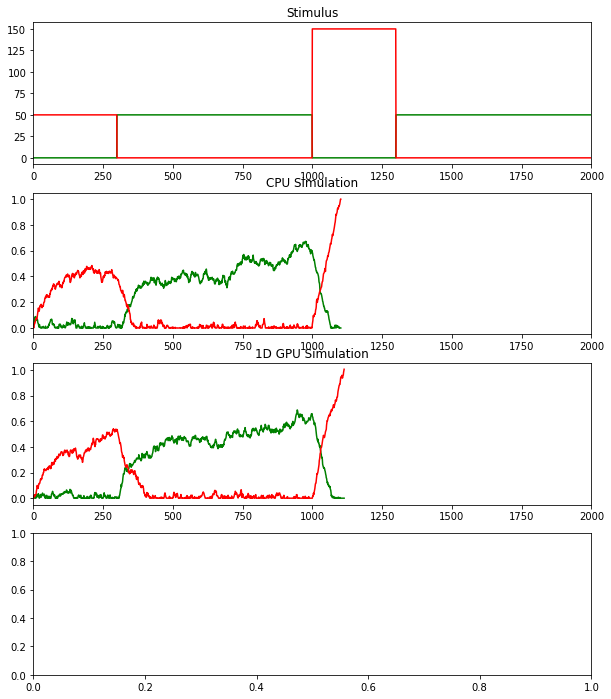

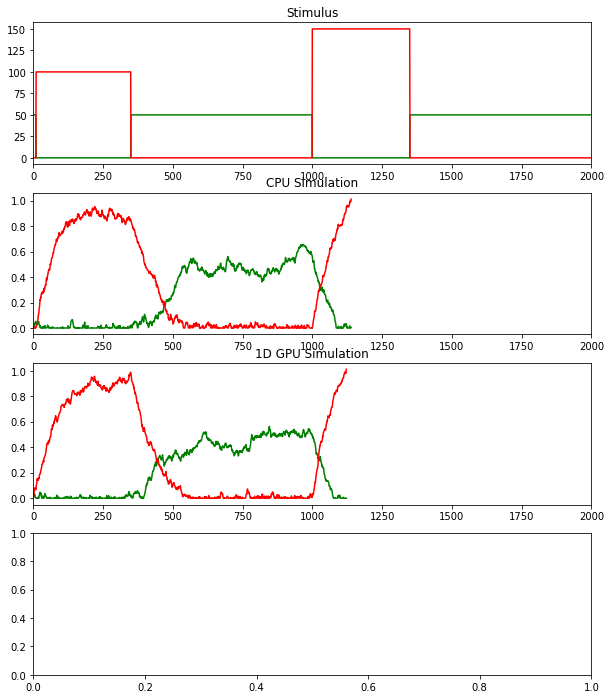

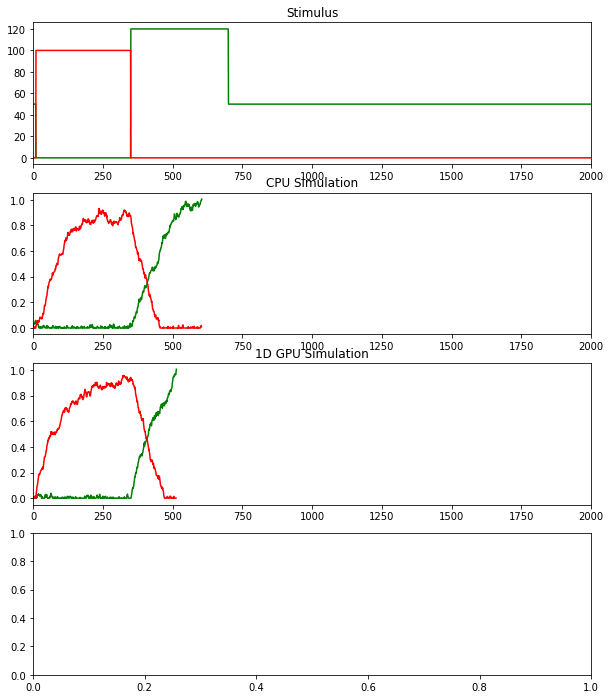

In [162]:
                
#for vectors arranged column-wise
@cuda.jit
def mat_sum_cuda(vec, output):
    output[0] = 0
    for _, val in enumerate(vec.flat):
        output[0] += val
        
@cuda.jit
def vec_multiplication_cuda(vector, scaler, output):
    ouput = 0
    for i in range(len(vector)):
        output[i] = vector[i]*scaler

                
# For Dynamic Coherence
@cuda.jit
def independent_accumulating_kernel(stimulus, starting_point, drift_gain, drift_variability, drift_offset, decision_bound, nondecision_time, lateral_inhibition, leak, neural_ddm, urgency_signal, decision, reaction_time, rng_states): 
    """ Cuda kernel for model with drift, leak, lateral inhibition (competiting), ddm like stimulus driven inhibition and urgency model. 
    Also works with within-trial dynamic stimulus, boundary and drift variability. Additionally, implementation of starting point offset and drift rate offset for bias terms.
    
    Note: Since cuda kernels cannot return values, we pass output variables to in function as mutable variables.
    
    Args:
        stimulus: Stimulus intensities with shape (num_trials, num_choices, num, time). Type: array(3D, float32)
        starting_point: 1D array of starting point for each accumulator with length equal to number of time steps. Type: array(1D, float32) 
        drift_gain: Common drift rate of accumulators (same for all accumulators). Type: float32
        drift_variability: Time-dependent drift-variability variability for each time point with length equal to number of time steps. Type array(1D, float32)
        drift_offset: Offset in drift-rate i.e., drift-rate in case of no/random stimulus with length equal to number of choices. Type: array(1D, float32) 
        decision_bound: Time dependent decision-bound. Array of length equal to number of time steps. Type: array(1D, float32)
        nondecision_time: Non-decision time. Type: float32
        lateral_inhibition: Waight of lateral inhibition from other accumulator. Type: float32
        leak: Leak factor from indivdual accumulator. Proportional to evidence in respective accumulator. Type: float32
        neural_ddm: DDM like lateral inhibition from drift-rate from other stimulus intensities. Type: bool
        urgency_signal: Boolean for linerly time-dependent urgency signal. Type: bool
        
    Output:
        decision: Decision on each trial as a number of accumulator (0:num_choices-1) with length equal to number of trials. Type: array(1D, float32)
        reaction_time: Reaction time on each trial with length equal to number of trials. Type: array(1D, float32)       
    
        
    Raises:
        TypeError: data must be a list or numpy array
        ValueError: data must be m by 3 matrix.

    Information:
        2022-03 VT write it
        
    """
    
#     import warnings    
#     # Input validation
#     # Stimulus
#     if not numba.cuda.is_cuda_array(stimulus) or stimulus_cp.dtype != 'float32':
#         warnings.warn('Data should be float32 array on GPU otherwise simulation will take longer time')
#     elif not isinstance(stimulus_np, np.ndarray) or not isinstance(stimulus_np, cp._core.core.ndarray):
#         raise TypeError('Stimulus must be numpy or cupy array')
#     elif stimulus.ndim < 2 or stimulus.ndim > 3:        
#         raise ValueError('Stimulus must be 2 or 3 dimensional array. \
#                          3-dimensional - (num_trials, num_choices, num_samples) \
#                          2-dimensional - (num_choices, num_samples)'
#                         )
           
#     if starting_point.shape != stimulus.shape[1]:        
#         raise ValueError('Must provide starting point as array with length eqaul to num_choices')
        
#     if drift_variability.shape != stimulus.shape[2]:        
#         raise ValueError('Must provide starting point as array with length eqaul to num_samples')
        
#     if drift_offset.shape != stimulus.shape[1]:        
#         raise ValueError('Must provide starting point as array with length eqaul to num_choices')
        
#     if decision_bound.shape != stimulus.shape[2]:        
#         raise ValueError('Must provide starting point as array with length eqaul to num_samples')
        
        
    decision_variable = cuda.local.array(num_choices, dtype=numba.float32)
    drift_rate = cuda.local.array(num_choices, dtype=numba.float32)
    sum_decision_variables = cuda.local.array(1, dtype=numba.float32)
    temp = cuda.local.array(1, dtype=numba.float32)
    start = cuda.grid(1)
    stride = cuda.gridsize(1)
    
    for tr in range(start, stimulus.shape[0], stride): 
        
        for accumulator in range(stimulus.shape[1]):
            decision_variable[accumulator] = starting_point[accumulator]        
        mat_sum_cuda(decision_variable, sum_decision_variables)
        boundary_reached = False
        
        for t in range(stimulus.shape[2]):
            vec_multiplication_cuda(stimulus[tr,:,t], drift_gain, drift_rate)             
            mat_sum_cuda(decision_variable, sum_decision_variables)
            for accumulator in range(stimulus.shape[1]):
                
                diffusion_step = drift_rate[accumulator] + drift_offset[accumulator] + (random.xoroshiro128p_normal_float32(rng_states, tr)*drift_variability[t])                
                leak_step = leak * decision_variable[accumulator]
                lateral_dv_inhibition_step = lateral_inhibition * (sum_decision_variables[0] - decision_variable[accumulator])  # Lateral inhibition from all decision_variables except self    
                ddm_like_dr_inhibition_step = numba.float32(0.0) 
                mat_sum_cuda(drift_rate,temp)
                ddm_like_dr_inhibition_step += temp[0] - drift_rate[accumulator]   # Collecting all drift-rate except current
                mat_sum_cuda(drift_offset,temp)
                ddm_like_dr_inhibition_step += temp[0] - drift_offset[accumulator] # Collecting all drift-offset except current   
                ddm_like_dr_inhibition_step = numba.float32(0.0) 
                mat_sum_cuda(drift_rate,temp)
                ddm_like_dr_inhibition_step += temp[0] - drift_rate[accumulator]   # Collecting all drift-rate except current
                mat_sum_cuda(drift_offset,temp)
                ddm_like_dr_inhibition_step += temp[0] - drift_offset[accumulator] # Collecting all drift-offset except current
                
                decision_step = decision_variable[accumulator] \
                                + diffusion_step \
                                - leak_step \
                                - lateral_dv_inhibition_step \
                                - ddm_like_dr_inhibition_step*neural_ddm
                
                decision_variable[accumulator] = decision_step * (decision_step > 0)
                decision[tr, accumulator, t] = decision_variable[accumulator]
                
                if decision_variable[accumulator] > decision_bound[t]:
                    boundary_reached = True
#                     decision[tr] = accumulator
                    reaction_time[tr] = t + nondecision_time
                    break
            if boundary_reached == True:
                break  
            

            
@cuda.jit
def independent_accumulating_kernel2(stimulus, starting_point, drift_gain, drift_variability, drift_offset, decision_bound, nondecision_time, lateral_inhibition, leak, neural_ddm, decision, reaction_time, rng_states): 

    decision_variable = cuda.local.array(num_choices, dtype=numba.float32)
    drift_rate = cuda.local.array(num_choices, dtype=numba.float32)
    sum_decision_variables = cuda.local.array(1, dtype=numba.float32)
    temp = cuda.local.array(1, dtype=numba.float32)
    
    start_tr, start_accumulator = cuda.grid(2)
    stride_tr, stride_accumulator = cuda.gridsize(2)
    h = cuda.cg.this_grid()

        
        
    for tr in range(start_tr, stimulus.shape[0], stride_tr): 
        
        # Instantiating decision variables with starting point
        for accumulator in range(stimulus.shape[1]):
            decision_variable[accumulator] = starting_point[accumulator]        
        mat_sum_cuda(decision_variable, sum_decision_variables)
        boundary_reached = False
        
        for t in range(stimulus.shape[2]):
            vec_multiplication_cuda(stimulus[tr,:,t], drift_gain, drift_rate)             
            mat_sum_cuda(decision_variable, sum_decision_variables)
                       
            for accumulator in range(start_accumulator, stimulus.shape[1], stride_accumulator):
                
                diffusion_step = drift_rate[accumulator] + drift_offset[accumulator] + (random.xoroshiro128p_normal_float32(rng_states, tr)*drift_variability[t])               
                leak_step = leak * decision_variable[accumulator]
                lateral_dv_inhibition_step = lateral_inhibition * (sum_decision_variables[0] - decision_variable[accumulator])  # Lateral inhibition from all decision_variables except self    
                ddm_like_dr_inhibition_step = numba.float32(0.0)                  # Initializing variable
                mat_sum_cuda(drift_rate,temp)
                ddm_like_dr_inhibition_step += temp[0] - drift_rate[accumulator]   # Collecting all drift-rate except current
                mat_sum_cuda(drift_offset,temp)
                ddm_like_dr_inhibition_step += temp[0] - drift_offset[accumulator] # Collecting all drift-offset except current   
                ddm_like_dr_inhibition_step = numba.float32(0.0) 
                mat_sum_cuda(drift_rate,temp)
                ddm_like_dr_inhibition_step += temp[0] - drift_rate[accumulator]   # Collecting all drift-rate except current
                mat_sum_cuda(drift_offset,temp)
                ddm_like_dr_inhibition_step += temp[0] - drift_offset[accumulator] # Collecting all drift-offset except current
                
                decision_step = decision_variable[accumulator] \
                                + diffusion_step \
                                - leak_step \
                                - lateral_dv_inhibition_step \
                                - ddm_like_dr_inhibition_step*neural_ddm
                
                decision_variable[accumulator] = decision_step * (decision_step > 0)
                decision[tr, accumulator, t] = decision_variable[accumulator]
                
                
                h.sync()
                
                if decision_variable[accumulator] > decision_bound[t]:
                    boundary_reached = True
#                     decision[tr] = accumulator
                    reaction_time[tr] = t + nondecision_time
                    break
                    
            if boundary_reached == True:
                break                   
            
            
            
            
def independent_accumulator(stimulus, starting_point, drift_gain, drift_variability, drift_offset, decision_bound, nondecision_time, decision, reaction_time): 
    for tr in range(stimulus.shape[0]):
        decision_variable = starting_point.copy()      
        sum_decision_variables = decision_variable.sum()
        boundary_reached = False
        for t in range(stimulus.shape[2]):            
            reached = 0
            sum_decision_variables = decision_variable.sum()
            drift_rate = stimulus[tr,:,t] * drift_gain
            for accumulator in range(stimulus.shape[1]):
                
                diffusion_step = drift_rate[accumulator] + drift_offset[accumulator] + (np.random.normal(0,1)*drift_variability[t])  
                leak_step = leak * decision_variable[accumulator]
                lateral_dv_inhibition_step = lateral_inhibition * (sum_decision_variables - decision_variable[accumulator])  # Lateral inhibition from all decision_variables except self
                ddm_like_dr_inhibition_step = drift_rate.sum() - drift_rate[accumulator] + drift_offset.sum() - drift_offset[accumulator]
                
                decision_step = decision_variable[accumulator] \
                                + diffusion_step \
                                - leak_step \
                                - lateral_dv_inhibition_step \
                                - ddm_like_dr_inhibition_step*neural_ddm
                
                decision_variable[accumulator] = decision_step * (decision_step > 0)
                decision[tr, accumulator, t] = decision_variable[accumulator]
                
                if decision_variable[accumulator] > decision_bound[t]:
                    boundary_reached = True
#                     decision[tr] = accumulator
                    reaction_time[tr] = t + nondecision_time
                    break
            if boundary_reached == True:
                break    
            
            
            
            
            
            
            
            
            
            
            
            
            
            
            
            
                    
                
num_choices = 2
num_trials = 3
num_samples = 2000

coherence = np.ones((num_trials,num_samples))*50     # 100
coherence[0,0:300] = -50
coherence[0,1000:1300] = -150
coherence[1,10:350] = -100
coherence[1,1000:1350] = -150
coherence[2,10:350] = -100
coherence[2,350:700] = 120

starting_point = np.zeros(num_choices, dtype=float32)             
drift_offset = np.zeros(num_choices, dtype=float32)
drift_gain = float32(10e-5)             # drift gain
drift_variability = float32(10e-3)      # diffusion variability
nondecision_time = float32(0)         # Non-decision time (msec)
decision_bound = 1
bound_rate = 0
bound_delay = 0
lateral_inhibition = 0.005
leak = 0.01
neural_ddm = 0.2
urgency_signal = False
# Dynamic time-dependent variables
stimulus_cp = cp.asarray(get_unsigned_coherence_matrix(coherence))
decision_bound_cp = get_time_dependent_bound(decision_bound, bound_rate, bound_delay)
drift_variability_cp = get_time_dependent_variability(drift_variability)
stimulus_np = cp.asnumpy(stimulus_cp)
decision_bound_np = cp.asnumpy(decision_bound_cp)
drift_variability_np = cp.asnumpy(drift_variability_cp)

decision1 = np.empty_like(stimulus_np)*np.NaN
# decision1 = np.empty(stimulus_np.shape[0])*np.NaN
reaction_time1 = np.empty(stimulus_np.shape[0])*np.NaN

decision2 = cp.empty_like(stimulus_cp)*cp.NaN
# decision2 = cp.empty(stimulus_cp.shape[0])*cp.NaN
reaction_time2 = cp.empty(stimulus_cp.shape[0])*cp.NaN

decision3 = cp.empty_like(stimulus_cp)*cp.NaN
# decision3 = cp.empty(stimulus_cp.shape[0])*cp.NaN
reaction_time3 = cp.empty(stimulus_cp.shape[0])*cp.NaN
                
independent_accumulator(stimulus_np, starting_point, drift_gain, drift_variability_np, drift_offset, decision_bound_np, nondecision_time, decision1, reaction_time1)           
                
blockdim = (256)
griddim = stimulus_cp.shape[0] // (blockdim) + 1
rng_states = random.create_xoroshiro128p_states(int(np.prod(blockdim) * np.prod(griddim)), seed=1)
cuda.synchronize()
independent_accumulating_kernel[griddim, blockdim](stimulus_cp, starting_point, drift_gain, drift_variability_cp, drift_offset, decision_bound_cp, nondecision_time, lateral_inhibition, leak, neural_ddm, urgency_signal, decision2, reaction_time2, rng_states) 
cuda.synchronize()


# blockdim = (128,1)
# griddim = (stimulus_cp.shape[0] // (blockdim[0]) + 1, stimulus_cp.shape[1] // (blockdim[1]) + 1)
# rng_states = random.create_xoroshiro128p_states(int(np.prod(blockdim) * np.prod(griddim)), seed=1)
# cuda.synchronize()
# independent_accumulating_kernel2[griddim, blockdim](stimulus_cp, starting_point, drift_gain, drift_variability_cp, drift_offset, decision_bound_cp, nondecision_time, lateral_inhibition, leak, neural_ddm, decision3, reaction_time3, rng_states) 
# cuda.synchronize()


# print(decision1, cp.asnumpy(decision2))
print(reaction_time1, cp.asnumpy(reaction_time2), cp.asnumpy(reaction_time3))



# For checking individual difference
for i in range(stimulus_np.shape[0]):    
# for i in range(stimulus_np.shape[0]):    
    fig, ax = plt.subplots(4,figsize=(10,12)) 
    ax[0].title.set_text('Stimulus')
    ax[0].plot(cp.asnumpy(stimulus_cp[i,0]),'g')
    ax[0].plot(cp.asnumpy(stimulus_cp[i,1]),'r')  
    ax[1].title.set_text('CPU Simulation')
    ax[1].plot(decision1[i,0],'g')
    ax[1].plot(decision1[i,1],'r')          
    ax[2].title.set_text('1D GPU Simulation')
    ax[2].plot(cp.asnumpy(decision2[i,0]),'g')    
    ax[2].plot(cp.asnumpy(decision2[i,1]),'r')
#     ax[3].title.set_text('2D GPU Simulation')
#     ax[3].plot(cp.asnumpy(decision3[i,0]),'g')    
#     ax[3].plot(cp.asnumpy(decision3[i,1]),'r')

    ax[0].set_xlim([0, num_samples])
    ax[1].set_xlim([0, num_samples])
    ax[2].set_xlim([0, num_samples])
#     ax[3].set_xlim([0, num_samples])
    plt.show()    
        
#     ax[0].set_xlim([0, reaction_time1[i]])
#     ax[1].set_xlim([0, cp.asnumpy(reaction_time2[i])])
#     ax[2].set_xlim([0, cp.asnumpy(reaction_time2[i])])
#     ax[3].set_xlim([0, cp.asnumpy(reaction_time2[i])])
#     plt.show()
    
    
# # For checking difference
# for i in range(stimulus_np.shape[0]):    
# # for i in range(stimulus_np.shape[0]):    
#     fig, ax = plt.subplots(5,figsize=(18,18)) 
#     ax[0].title.set_text('Stimulus')
#     ax[0].plot(cp.asnumpy(stimulus_cp[i,0]),'g')
#     ax[0].plot(cp.asnumpy(stimulus_cp[i,1]),'r')  
#     ax[1].title.set_text('1D GPU Simulation Green Diff')
#     ax[1].plot(decision1[i,0] - cp.asnumpy(decision2[i,0]),'g')        
#     ax[2].title.set_text('1D GPU Simulation Red Diff')   
#     ax[2].plot(decision1[i,1] - cp.asnumpy(decision2[i,1]),'r')  
#     ax[3].title.set_text('2D GPU Simulation Green Diff')
#     ax[3].plot(decision1[i,0] - cp.asnumpy(decision3[i,0]),'g')        
#     ax[4].title.set_text('2D GPU Simulation Red Diff')   
#     ax[4].plot(decision1[i,1] - cp.asnumpy(decision3[i,1]),'r')  

# #     ax[0].set_xlim([0, num_samples])
# #     ax[1].set_xlim([0, num_samples])
# #     ax[2].set_xlim([0, num_samples])
# #     ax[3].set_xlim([0, num_samples])
# #     ax[4].set_xlim([0, num_samples])
    
#     ax[0].set_xlim([0, reaction_time1[i]])
#     ax[1].set_xlim([0, cp.asnumpy(reaction_time2[i])])
#     ax[2].set_xlim([0, cp.asnumpy(reaction_time2[i])])
#     ax[3].set_xlim([0, cp.asnumpy(reaction_time3[i])])
#     ax[4].set_xlim([0, cp.asnumpy(reaction_time3[i])])
#     plt.show()




<br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br>



<br><br><br><br><br><br><br><br><br><br>


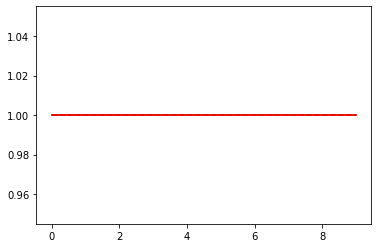

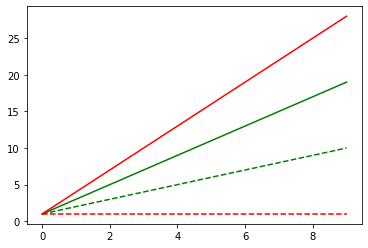

In [ ]:
@cuda.jit                
def sum_check(a,b):
    
#     decision_variable = cuda.local.array(num_choices, dtype=numba.float32)
    
    start = cuda.grid(1)
    stride = cuda.gridsize(1)
    
    for tr in range(start, num_trials, stride): 
        for t in range(num_samples):
            for accu in range(num_choices):
                a[tr,accu,t] += (accu+1)*t
                b[tr,accu,t] += (accu)*t*3

num_trials = 2
num_choices = 2
num_samples = 10

a = cp.ones((num_trials,num_choices,num_samples))     # 100
b = cp.ones((num_trials,num_choices,num_samples))     # 100
plt.plot(cp.asnumpy(a[0,0]),'g--')
plt.plot(cp.asnumpy(a[0,1]),'g')
plt.plot(cp.asnumpy(b[0,0]),'r--')
plt.plot(cp.asnumpy(b[0,1]),'r')
plt.show()

multiplier = 8
blockdim = (multiplier*32)
griddim = 80
cuda.synchronize()
sum_check[griddim, blockdim](a,b)
cuda.synchronize()


plt.plot(cp.asnumpy(a[0,0]),'g--')
plt.plot(cp.asnumpy(a[0,1]),'g')
plt.plot(cp.asnumpy(b[0,0]),'r--')
plt.plot(cp.asnumpy(b[0,1]),'r')
